# SARIMAX on electricity carbon intensity

The website [**electricitymap.org**](https://electricitymap.org) provides real-time data-viz about the origin of electricity consumed around the world. In particular, it provides (sub) hourly view of the CO2-intensity of electricity in grams of CO2-equivalent per kWh electricity consumed (gCO2e/kWh).

<img src='electricitymap.jpg' width = 500>


Carbon intensity flucutates a lot depending on seasons, weather conditions, imports from neighbors countries, etc...

Your goal is to **forecast the hourly carbon intensity of electricity in France up to 48 hours ahead** so as to inform when is best to consumer electricity (e.g. charge electric car)

## Challenge

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Load the 50Mo CSV!
df = pd.read_csv('electricity_map_france.csv', parse_dates=['datetime'], index_col=['datetime'])
print(df.shape)
df = df['2016':]
print(df.shape)

(58948, 72)
(32691, 72)


In [ ]:
df.info()

### Your challenge
- Your goal is to predict `carbon_intensity_avg` up to 48h ahead.
- We have 6 years of data at hourly granularity! Enough to make proper `cross_validated` score of `rmpe` over the whole dataset!
- You have access to exogeneous forecast prefixed by `latest_forecasted_` 
    - e.g. you can use `latest_forecasted_price_avg(t+i)` when trying to predict `carbon_intensity_avg(t+i)`
    - for i in [1..48]

### Hints

- You can build a `SARMIAX` model with `exog` features
- Or, you can build your own "traditional" ML-based model, optimizing for the 48h ahead time horizon

## Your turn

In [5]:
y = df['carbon_intensity_avg']

<AxesSubplot:xlabel='datetime'>

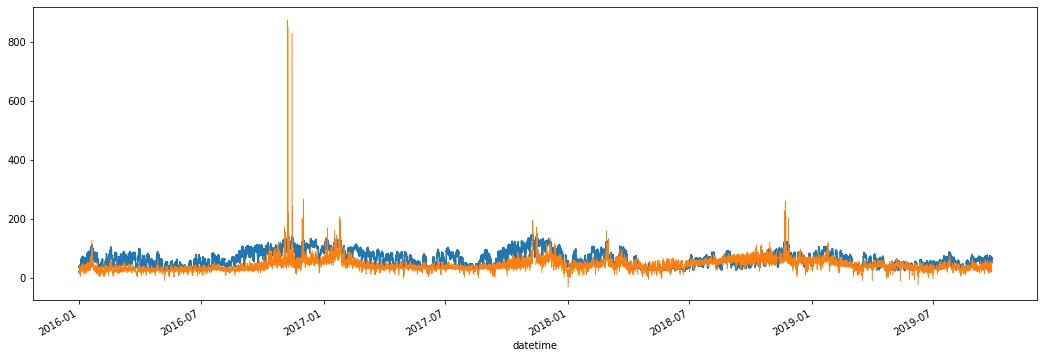

In [12]:
# %matplotlib widget
y.plot()
df.latest_forecasted_price_avg.plot(linewidth = 0.5,figsize=(18,6))

In [13]:
df.columns

Index(['timestamp', 'zone_name', 'carbon_intensity_avg',
       'carbon_intensity_production_avg', 'carbon_intensity_discharge_avg',
       'carbon_intensity_import_avg', 'carbon_rate_avg',
       'total_production_avg', 'total_storage_avg', 'total_discharge_avg',
       'total_import_avg', 'total_export_avg', 'total_consumption_avg',
       'production_sources', 'power_origin_percent_fossil_avg',
       'power_origin_percent_renewable_avg', 'power_production_biomass_avg',
       'power_production_coal_avg', 'power_production_gas_avg',
       'power_production_hydro_avg', 'power_production_nuclear_avg',
       'power_production_oil_avg', 'power_production_solar_avg',
       'power_production_wind_avg', 'power_production_geothermal_avg',
       'power_production_unknown_avg', 'power_consumption_biomass_avg',
       'power_consumption_coal_avg', 'power_consumption_gas_avg',
       'power_consumption_hydro_avg', 'power_consumption_nuclear_avg',
       'power_consumption_oil_avg', 'power_c

In [14]:
df

,timestamp,zone_name,carbon_intensity_avg,carbon_intensity_production_avg,carbon_intensity_discharge_avg,carbon_intensity_import_avg,carbon_rate_avg,total_production_avg,total_storage_avg,total_discharge_avg,...,latest_forecasted_production_avg,latest_forecasted_consumption_avg,latest_forecasted_power_net_import_BE_avg,latest_forecasted_power_net_import_CH_avg,latest_forecasted_power_net_import_DE_avg,latest_forecasted_power_net_import_ES_avg,latest_forecasted_power_net_import_GB_avg,latest_forecasted_power_net_import_IT-NO_avg,latest_forecasted_production_solar_avg,latest_forecasted_production_wind_avg
datetime,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00+00:00,1451606400,FR,37.770414,35.303678,47.609819,192.760637,2.177719e+09,61724.000000,0.000000,320.75,...,62205.0,56550.0,717.0,-3060.0,2467.0,-2600.0,-1760.0,-1494.0,0.0,2003.0
2016-01-01 01:00:00+00:00,1451610000,FR,37.918853,35.565320,47.609819,187.805448,2.144070e+09,61291.800000,441.150000,0.00,...,60615.0,56150.0,748.0,-3046.0,2664.0,-2600.0,-1760.0,-1494.0,0.0,1744.0
2016-01-01 02:00:00+00:00,1451613600,FR,38.825366,36.054368,NaN,197.659253,2.065981e+09,59770.525424,2608.372881,0.00,...,56584.0,52600.0,782.0,-3060.0,3362.0,-2600.0,-1760.0,-1494.0,0.0,1490.0
2016-01-01 03:00:00+00:00,1451617200,FR,38.092022,36.558120,NaN,185.864276,1.922009e+09,58774.500000,3061.500000,0.00,...,56541.0,49750.0,323.0,-3011.0,2040.0,-2600.0,-1760.0,-1494.0,0.0,1238.0
2016-01-01 04:00:00+00:00,1451620800,FR,37.066029,36.664417,NaN,185.349104,1.856452e+09,58342.500000,2321.500000,0.00,...,56919.0,48850.0,-131.0,-2991.0,1671.0,-2600.0,-1760.0,-1494.0,0.0,1173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-26 04:00:00+00:00,1569470400,FR,61.804862,58.569958,NaN,182.849166,2.600903e+09,50709.000000,1352.500000,0.00,...,51512.0,41100.0,81.0,-2294.0,-51.0,-1208.0,-882.0,-2691.0,0.0,3705.0
2019-09-26 05:00:00+00:00,1569474000,FR,66.438741,61.683200,47.609819,216.070264,3.173729e+09,52680.750000,0.000000,287.50,...,54521.0,47450.0,994.0,-2294.0,-1778.0,439.0,692.0,-2737.0,0.0,3724.0
2019-09-26 06:00:00+00:00,1569477600,FR,68.071275,61.394931,47.609819,247.320312,3.391532e+09,53636.000000,0.000000,759.25,...,55827.0,49900.0,1162.0,-2260.0,-1682.0,1098.0,250.0,-2737.0,13.0,3742.0


# Version fb_prophet